importing the required libraries

In [2]:
import torch
import torchvision.datasets as ds
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as tr
import torchvision.models as md
import  torch.optim as optim
from torch.utils.data import random_split
import intel_extension_for_pytorch as ipex
import numpy 
from torchvision import transforms
from PIL import Image

importing the data

In [3]:

fashion_mnist = ds.FashionMNIST(download=False, train=True, root="fashion_mnist_data").train_data.float()

data_transform = transforms.Compose([ transforms.Resize((28, 28)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])
trainset = ds.FashionMNIST(root='fashion_mnist_data',
                                      train=True,
                                      download=True,
                                      transform=data_transform,
                                      )


testset = ds.FashionMNIST(root='fashion_mnist_data',
                                     train=False,
                                     download=True,
                                     transform=data_transform
                                    )

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


splitting the data into training, validation and tresting sets

In [4]:
train_set, val_set = torch.utils.data.random_split(trainset, [50000, 10000])

visualizing an image

0
torch.Size([1, 28, 28])
0


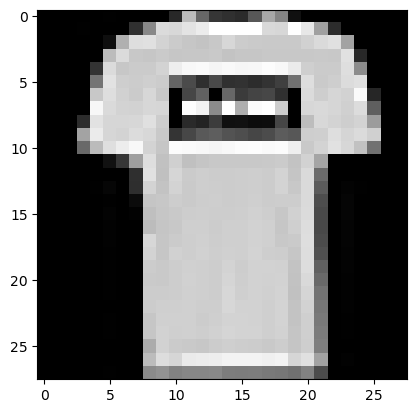

In [5]:
import matplotlib.pyplot as plt
num_row = 4
num_col = 5
num=20
# plot images
image , label = trainset[1]
print(label)
#plt.imshow(images)
print(image.shape)
labels = str(label)
plt.imshow(image.reshape(28,28), cmap = 'gray')
print(label)

loading the data using dataloader

In [6]:
batchsize=128
traindlr = DataLoader(train_set,batchsize,shuffle =True)
valdlr = DataLoader(val_set,batchsize,shuffle =False)
testdlr = DataLoader(testset,batchsize,shuffle =False)

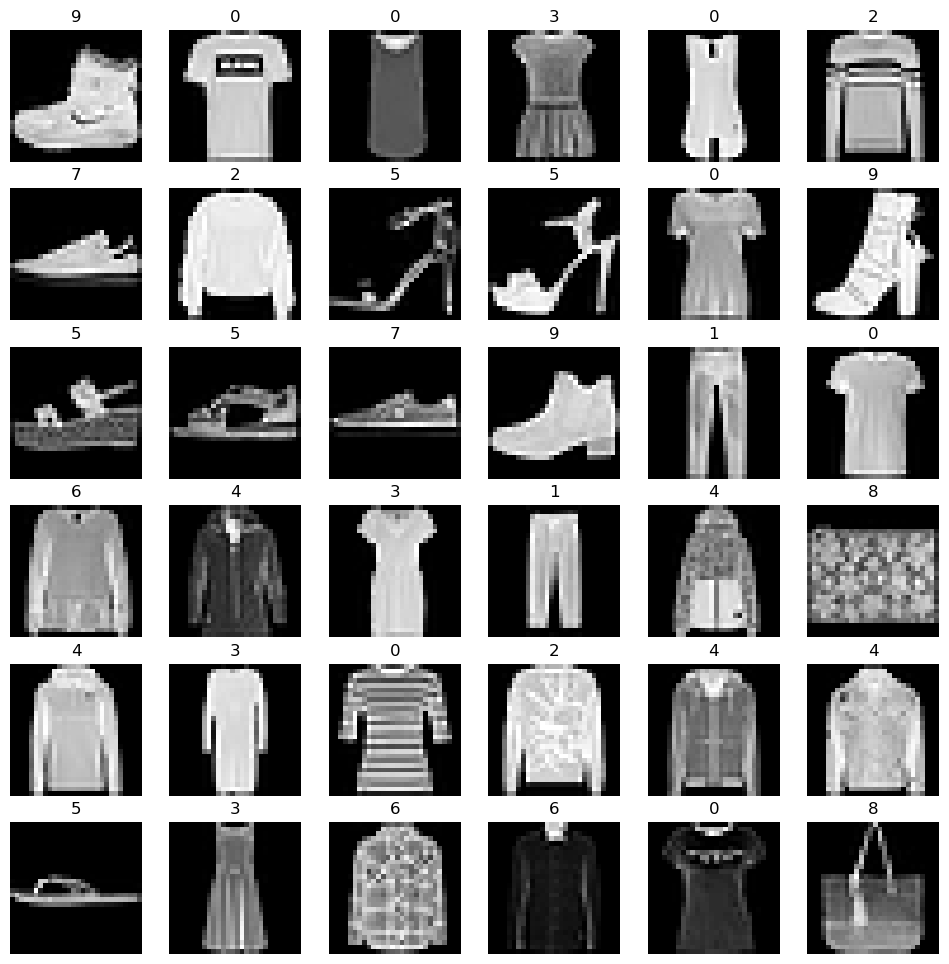

In [7]:
plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(36):
    ax1 = plt.subplot(6,6,i+1)
    images , labels = trainset[i]
    plt.imshow(images.reshape(28,28).detach().numpy(),cmap='gray')
    plt.title(labels)
    plt.axis('off')
plt.show()

building a CNN using resnet18

In [9]:
class resmnist(nn.Module):
    def __init__(self,in_chan=1):
        super(resmnist,self).__init__()
        self.model = md.resnet18(pretrained = True)
        self.model.conv1 = nn.Conv2d(in_chan, 64,kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)


my_resnet = resmnist()

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


implementing cross entropy loss function and adam optimizer

In [10]:
net = resmnist().to('cpu')           # Creating object for LeNet() model and passing it to GPU 

loss_fn = nn.CrossEntropyLoss()    # It takes the highest value which is the predictions and mark it as 1                                # And mark rest of the values as zeros. 
opt = optim.Adam(net.parameters())


function to find the accuracy of train set and val set

In [11]:
def evaluation(DataLoader):
    total , correct = 0,0
    for data in DataLoader:
        inputs , labels = data
        inputs = inputs.to('cpu') 
        labels = labels.to('cpu')
        output = net(inputs)            
        max_pred,pred = torch.max(output.data,dim=1)
        total +=labels.size(0)
        correct = correct + ((pred == labels).sum().item())  
    return 100 * correct / total 

training the model

In [13]:
loss_arr = []
loss_epoch_arr = []
val_loss_arr = []
acc_arr=[]
val_acc_arr=[]
def fit(max_epochs):
    batches = len(traindlr)
    val_batches = len(valdlr)
    for epoch in range(max_epochs):
        total_loss= 0 
        net.train()
        for i, data in enumerate(traindlr): # Iterating through the train loader 
            inputs,labels = data
            inputs,labels = inputs.to('cpu'),labels.to('cpu')


            opt.zero_grad()     # Reset the gradient in every iteration
            outputs = net(inputs)
            loss = loss_fn(outputs,labels)   # Loss forward pass
            loss.backward()# Loss backaed pass
            opt.step()# Update all the parameters by the given learnig rule
            total_loss += loss.item()
        loss_arr.append(total_loss)
        val_loss=0
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(valdlr): # Iterating through the val loader 
                inputs,labels = data
                inputs,labels = inputs.to('cpu'),labels.to('cpu')

                outputs = net(inputs)
                val_loss += loss_fn(outputs,labels).item()   # Loss forward pass
        val_loss_arr.append(val_loss)
            
        print('Val accuracy: %0.2f , Train accuracy : %0.2f'%(evaluation(valdlr),evaluation(traindlr)))
        acc_arr.append(evaluation(traindlr))
        val_acc_arr.append(evaluation(valdlr))
        print('Val loss:'+ str(val_loss/val_batches) +' Train loss'+ str(total_loss/batches))

max_epochs = 15

    
fit(max_epochs)

Val accuracy: 88.47 , Train accuracy : 90.08
Val loss:0.33529940511606915 Train loss0.28793616932066507
Val accuracy: 88.73 , Train accuracy : 91.03
Val loss:0.3266148957647855 Train loss0.25540052325752993
Val accuracy: 89.38 , Train accuracy : 92.07
Val loss:0.2875331025334853 Train loss0.22993761112394234
Val accuracy: 90.20 , Train accuracy : 92.97
Val loss:0.26606554745496075 Train loss0.2071049859952134
Val accuracy: 90.29 , Train accuracy : 93.75
Val loss:0.26051790889682647 Train loss0.191735764989234
Val accuracy: 90.35 , Train accuracy : 94.43
Val loss:0.2754347129147264 Train loss0.1790708549835188
Val accuracy: 91.02 , Train accuracy : 95.22
Val loss:0.26507962938350965 Train loss0.159031265846375
Val accuracy: 90.25 , Train accuracy : 94.96
Val loss:0.27782342158540896 Train loss0.14267907400265376
Val accuracy: 90.74 , Train accuracy : 96.21
Val loss:0.27519410169577296 Train loss0.12935457855958463
Val accuracy: 90.67 , Train accuracy : 96.53
Val loss:0.28761959344714505

In [ ]:
import matplotlib.pyplot
a=[]
b=1
for i in range (1,max_epochs+1):
    a.append(b)
    b += 1
    

plot for train_loss and val_loss vs no of epochs

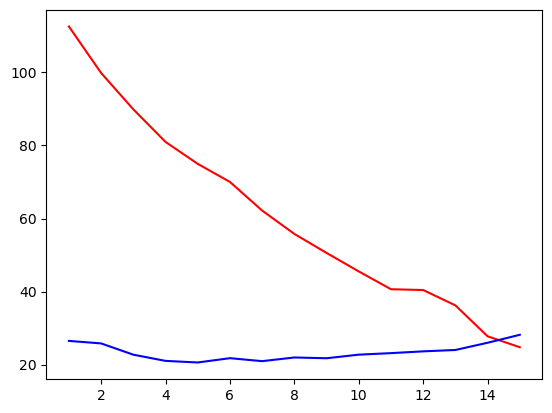

In [15]:
plt.plot(a,loss_arr,c='r')
plt.plot(a,val_loss_arr,c='b')

plot for train accuracy and val accuracy vs no of epochs

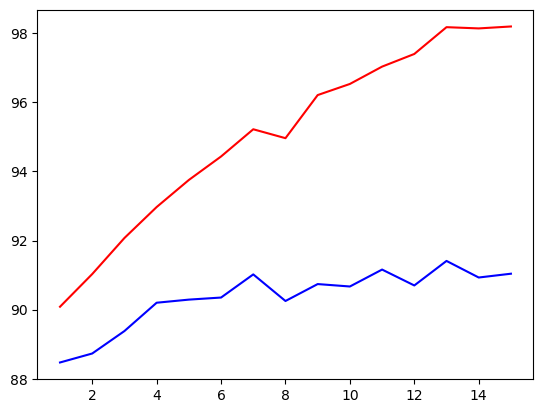

In [16]:
plt.plot(a,acc_arr,c='r')
plt.plot(a,val_acc_arr,c='b')

testing the model using the testing data

In [92]:
print(len(testdlr))
for i, data in enumerate(testdlr): # Iterating through the train loader 
            inputs,labels = data
            inputs,labels = inputs.to('cpu'),labels.to('cpu')
            op = net(inputs)
print(torch.max(op,1))
print(labels)    


79
torch.return_types.max(
values=tensor([11.5860,  2.4646, 14.6623, 10.8623, 15.5450,  7.9438, 10.8155,  9.0719,
         5.6858,  7.7419,  8.6377, 11.5762, 11.2002,  8.7843, 19.1343,  0.9333],
       grad_fn=<MaxBackward0>),
indices=tensor([3, 3, 7, 5, 8, 4, 5, 2, 8, 9, 1, 9, 1, 8, 1, 5]))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])


showing the effects of intel optimizations

In [32]:
import time
for i, data in enumerate(traindlr): # Iterating through the train loader 
    inputs1,labels = data
    inputs1,labels = inputs1.to('cpu'),labels.to('cpu')

def measure_latency(model,input1):

    with torch.no_grad():
        for i in range(25):
            model(inputs1)
        start_time = time.time()
        for i in range(25):
            model(inputs1)
        end_time = time.time()
    n = 1000*(end_time - start_time)/25
    print('before optimization: ' + str(n))
    
    net.eval()
    ipex.optimize(net)
    with torch.no_grad():
        for i in range(25):
            model(inputs1)
        start_time = time.time()
        for i in range(25):
            model(inputs1)
        end_time = time.time()
    n = 1000*(end_time - start_time)/25
    print('after optimization: ' + str(n))
  
measure_latency(net,inputs1)


before optimization: 16.325321197509766
after optimization: 14.715089797973633
